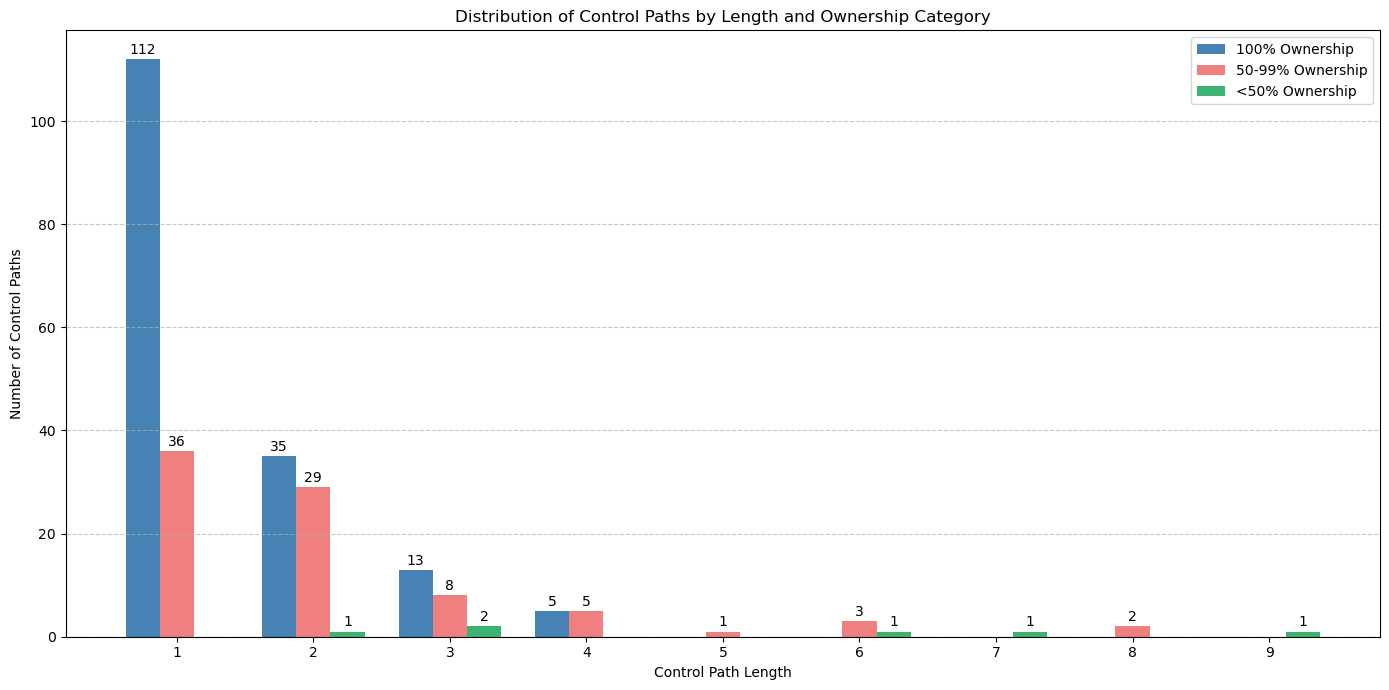


Ultimate Controlling Shareholders and Their Complete Control Paths (sorted by Path Length):
 Rank  Shareholder ID  Company ID Ownership Percent  Path Length                    Control Path                     is_terminal_control
   1        365           473          100.00%           1                                               [365, 473]         True        
   2        384           734          100.00%           1                                               [384, 734]         True        
   3        391           920          100.00%           1                                               [391, 920]         True        
   4        233           880          100.00%           1                                               [233, 880]         True        
   5        326           562          100.00%           1                                               [326, 562]         True        
   6        980           508          100.00%           1                           

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = "D:\\布里斯托课程\\MDM\\synthetic_company_structures_500_links.csv"
df = pd.read_csv(file_path)

# Step 2: Create a directed graph for ownership relationships (>50% ownership)
G = nx.DiGraph()

# Add edges with weights (ownership percentages)
for _, row in df.iterrows():
    # Only add edges with >50% ownership (effective control)
    if row['shareholder_percent'] > 50:
        G.add_edge(int(row['shareholder_id']), int(row['company_id']), 
                  weight=row['shareholder_percent'])

# Step 3: Identify ultimate controlling shareholders (nodes with in-degree = 0)
ultimate_shareholders = []
for node in G.nodes():
    if G.in_degree(node) == 0:
        ultimate_shareholders.append(node)

# Step 4: Trace control paths from ultimate shareholders
ultimate_control_paths = []
shareholder_max_paths = {}  # To track longest path for each shareholder

def dfs_control_paths(node, path, ownership_pct):
    current_path = path + [node]
    
    # For each company controlled by this shareholder
    for neighbor in G.successors(node):
        # Skip if already in path (avoid cycles)
        if neighbor in current_path:
            continue
            
        # Get ownership percentage
        edge_weight = G[node][neighbor]['weight']
        
        # Calculate cumulative ownership
        new_ownership = ownership_pct * (edge_weight / 100.0)
        
        # Determine if this company controls others
        is_terminal = True
        for next_neighbor in G.successors(neighbor):
            is_terminal = False
            break
        
        # New path including this company
        full_path = current_path + [neighbor]
        
        # Only record terminal control paths (companies that don't control others)
        if is_terminal:
            path_info = {
                'Ultimate Shareholder': path[0] if path else node,
                'Controlled Company': neighbor,
                'Ownership Percent': new_ownership * 100,
                'Path Length': len(full_path) - 1,  # Number of edges in the path
                'Control Path': full_path,
                'is_terminal_control': is_terminal
            }
            ultimate_control_paths.append(path_info)
            
            # Track longest path for each ultimate shareholder
            ultimate_shareholder = path[0] if path else node
            if ultimate_shareholder not in shareholder_max_paths or \
               shareholder_max_paths[ultimate_shareholder]['Path Length'] < path_info['Path Length']:
                shareholder_max_paths[ultimate_shareholder] = path_info
        
        # Continue DFS
        dfs_control_paths(neighbor, current_path, new_ownership)

# Perform DFS from each ultimate shareholder
for shareholder in ultimate_shareholders:
    dfs_control_paths(shareholder, [], 1.0)

# Convert to DataFrame and format
df_ultimate = pd.DataFrame(ultimate_control_paths)

# Store numeric ownership percentage for calculations
df_ultimate['Ownership_Float'] = df_ultimate['Ownership Percent']

# Reorder and rename columns
df_ultimate = df_ultimate.rename(columns={
    'Ultimate Shareholder': 'Shareholder ID',
    'Controlled Company': 'Company ID'
})

# Format ownership percentage for display
df_ultimate['Ownership Percent'] = df_ultimate['Ownership Percent'].apply(lambda x: f"{x:.2f}%")

# Add ownership category based on actual percentage
df_ultimate['Ownership Category'] = df_ultimate['Ownership_Float'].apply(
    lambda x: '100% Ownership' if x == 100 else 
              '50-99% Ownership' if x >= 50 else 
              '<50% Ownership')

# Sort by Path Length (ascending)
df_ultimate = df_ultimate.sort_values(by=['Path Length', 'Ownership_Float'], ascending=[True, False])

# Add rank after sorting
df_ultimate.insert(0, 'Rank', range(1, len(df_ultimate) + 1))

# Select and order columns for display (removed 'Ownership Category')
display_columns = ['Rank', 'Shareholder ID', 'Company ID', 'Ownership Percent', 
                   'Path Length', 'Control Path', 'is_terminal_control']

# Create summary by longest path and ownership category for each shareholder
max_paths_df = pd.DataFrame(list(shareholder_max_paths.values()))
max_paths_df['Ownership Category'] = max_paths_df['Ownership Percent'].apply(
    lambda x: '100% Ownership' if x == 100 else 
              '50-99% Ownership' if x >= 50 else 
              '<50% Ownership')

# Group by path length and ownership category for shareholder distribution table
summary_df = max_paths_df.groupby(['Path Length', 'Ownership Category']).size().reset_index(
    name='Number of Shareholders')
summary_df = summary_df.rename(columns={'Path Length': 'Longest Path Length'})

# Sort by path length and ownership category
summary_df = summary_df.sort_values(by=['Longest Path Length', 'Ownership Category'])

# CORRECTED: Create Control Complexity table based on ALL paths, not just one per shareholder
# Count all paths by length and ownership category
all_paths_by_complexity = {
    'Simple (Path Length = 1)': df_ultimate[df_ultimate['Path Length'] == 1].groupby('Ownership Category').size(),
    'Moderate (Path Length = 2-3)': df_ultimate[(df_ultimate['Path Length'] >= 2) & 
                                             (df_ultimate['Path Length'] <= 3)].groupby('Ownership Category').size(),
    'Complex (Path Length ≥ 4)': df_ultimate[df_ultimate['Path Length'] >= 4].groupby('Ownership Category').size()
}

# Convert to DataFrame
complexity_df = pd.DataFrame(all_paths_by_complexity).fillna(0).astype(int)
complexity_df['Total Paths'] = complexity_df.sum(axis=1)

# Create a histogram showing ALL paths by path length and ownership category
plt.figure(figsize=(14, 7))

# Get data for the histogram - count all paths, not just one per shareholder
path_length_counts = df_ultimate.groupby(['Path Length', 'Ownership Category']).size().unstack()

# Fill missing categories with 0
for category in ['100% Ownership', '50-99% Ownership', '<50% Ownership']:
    if category not in path_length_counts.columns:
        path_length_counts[category] = 0

# Create histogram with multiple bars (three categories)
bar_width = 0.25  # Narrower bars to accommodate three categories
index = np.arange(len(path_length_counts.index))

plt.bar(index - bar_width, path_length_counts['100% Ownership'], 
        bar_width, label='100% Ownership', color='steelblue')
plt.bar(index, path_length_counts['50-99% Ownership'], 
        bar_width, label='50-99% Ownership', color='lightcoral')
plt.bar(index + bar_width, path_length_counts['<50% Ownership'], 
        bar_width, label='<50% Ownership', color='mediumseagreen')

# Add labels and title
plt.xlabel('Control Path Length')
plt.ylabel('Number of Control Paths')
plt.title('Distribution of Control Paths by Length and Ownership Category')
plt.xticks(index, path_length_counts.index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(path_length_counts['100% Ownership']):
    if v > 0:
        plt.text(i - bar_width, v + 1, str(int(v)), ha='center')
        
for i, v in enumerate(path_length_counts['50-99% Ownership']):
    if v > 0:
        plt.text(i, v + 1, str(int(v)), ha='center')

for i, v in enumerate(path_length_counts['<50% Ownership']):
    if v > 0:
        plt.text(i + bar_width, v + 1, str(int(v)), ha='center')

# Display the figure
plt.tight_layout()
plt.show()

# Set display options for better formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

# Print the formatted main table
print("\nUltimate Controlling Shareholders and Their Complete Control Paths (sorted by Path Length):")
print("="*120)
print(df_ultimate[display_columns].to_string(index=False))
print("="*120)
print(f"Total ultimate controlling shareholders: {len(ultimate_shareholders)}")
print(f"Total complete control paths: {len(df_ultimate)}")

# Display shareholder distribution table
print("\nTable: Shareholder Distribution by Longest Control Path Length and Ownership Category")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Display corrected complexity table
print("\nTable: Control Complexity by Ownership Category (All Paths)")
print("="*100)
print(complexity_df.to_string())
print("="*100)